##Importação e análises iniciais


In [6]:
# ================================
# Importar bibliotecas
# ================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# ================================
# Função para remover outliers (IQR) de várias colunas de uma vez
# ================================
def remover_outliers_iqr(df, colunas):
    mask = pd.Series(True, index=df.index)  # Máscara inicial (tudo True)
    for coluna in colunas:
        Q1 = df[coluna].quantile(0.25)
        Q3 = df[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inf = Q1 - 1.5 * IQR
        limite_sup = Q3 + 1.5 * IQR
        mask &= (df[coluna] >= limite_inf) & (df[coluna] <= limite_sup)
    print(f"Linhas antes: {df.shape[0]}, depois: {mask.sum()} (removidos {df.shape[0] - mask.sum()})")
    return df[mask].copy()

# ================================
# Carregar dataset
# ================================
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# ================================
# Limpeza inicial
# ================================
df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], inplace=True)  # Colunas constantes
df.drop(columns=['EmployeeNumber'], inplace=True)  # Identificador

# Variável alvo binária
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# ================================
# Separar colunas numéricas e categóricas
# ================================
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('Attrition')  # Não incluir a target
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

# ================================
# Remover outliers
# ================================
# Evitar remover de colunas já naturalmente limitadas, se desejar
colunas_para_outliers = [col for col in numeric_cols if df[col].nunique() > 5]
df = remover_outliers_iqr(df, colunas_para_outliers)

# ================================
# One-Hot Encoding para categóricas
# ================================
df_encoded = pd.get_dummies(df, drop_first=True)

# ================================
# Escalonamento (apenas nas numéricas originais)
# ================================
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

scaler = StandardScaler()
num_cols_encoded = [col for col in numeric_cols if col in X.columns]
X[num_cols_encoded] = scaler.fit_transform(X[num_cols_encoded])

# ================================
# Divisão em treino e teste
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# Verificação final
# ================================
print("\n--- Verificações finais ---")
print("Formato X_train:", X_train.shape)
print("Formato X_test:", X_test.shape)
print("Distribuição y_train:\n", y_train.value_counts(normalize=True))
print("Distribuição y_test:\n", y_test.value_counts(normalize=True))

Numéricas: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Linhas antes: 1470, depois: 985 (removidos 485)

--- Verificações finais ---
Formato X_train: (788, 44)
Formato X_test: (197, 44)
Distribuição y_train:
 Attrition
0    0.824873
1    0.175127
Name: proportion, dtype: float64
Distribuição y_test:
 Attrition
0    0.822335
1    0.177665
Name: proportion, dtype: float64


##Variável Alvo
Vamos começar visualizando a distribuição da variável alvo 'Attrition'.


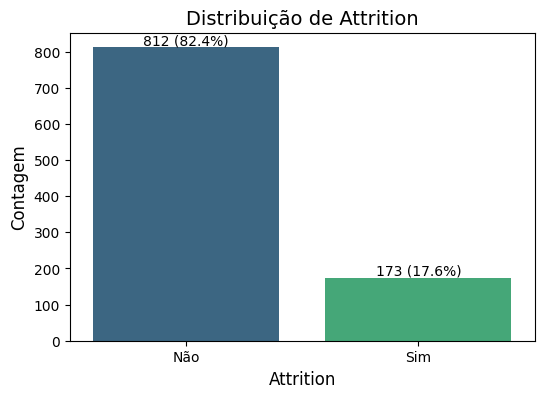

In [ ]:
# ================================
# Cria a figura e o gráfico de contagem
# ================================
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='Attrition',
    hue='Attrition',       # Evita aviso de depreciação
    data=df,
    palette='viridis', # Changed palette to a valid name
    legend=False           # Não precisa da legenda duplicada
)

# ================================
# Total de registros (pra calcular %)
# ================================

total = len(df)

# ================================
# Escrever a contagem e a porcentagem em cima de cada barra
# ================================
for barra in ax.patches:
    altura = barra.get_height()
    ax.annotate(
        f'{altura:.0f} ({altura / total:.1%})',
        (barra.get_x() + barra.get_width() / 2, altura),
        ha='center', va='bottom',
        fontsize=10
    )

# ================================
# Ajustes de título e eixos
# ================================
ax.set_title('Distribuição de Attrition', fontsize=14)
ax.set_xlabel('Attrition', fontsize=12)
ax.set_ylabel('Contagem', fontsize=12)

# ================================
# Troca os rótulos do eixo X
# ================================
ax.set_xticks([0, 1])
ax.set_xticklabels(['Não', 'Sim'])

plt.show()


##Histogramas
Os histogramas foram gerados e separados por attrition.


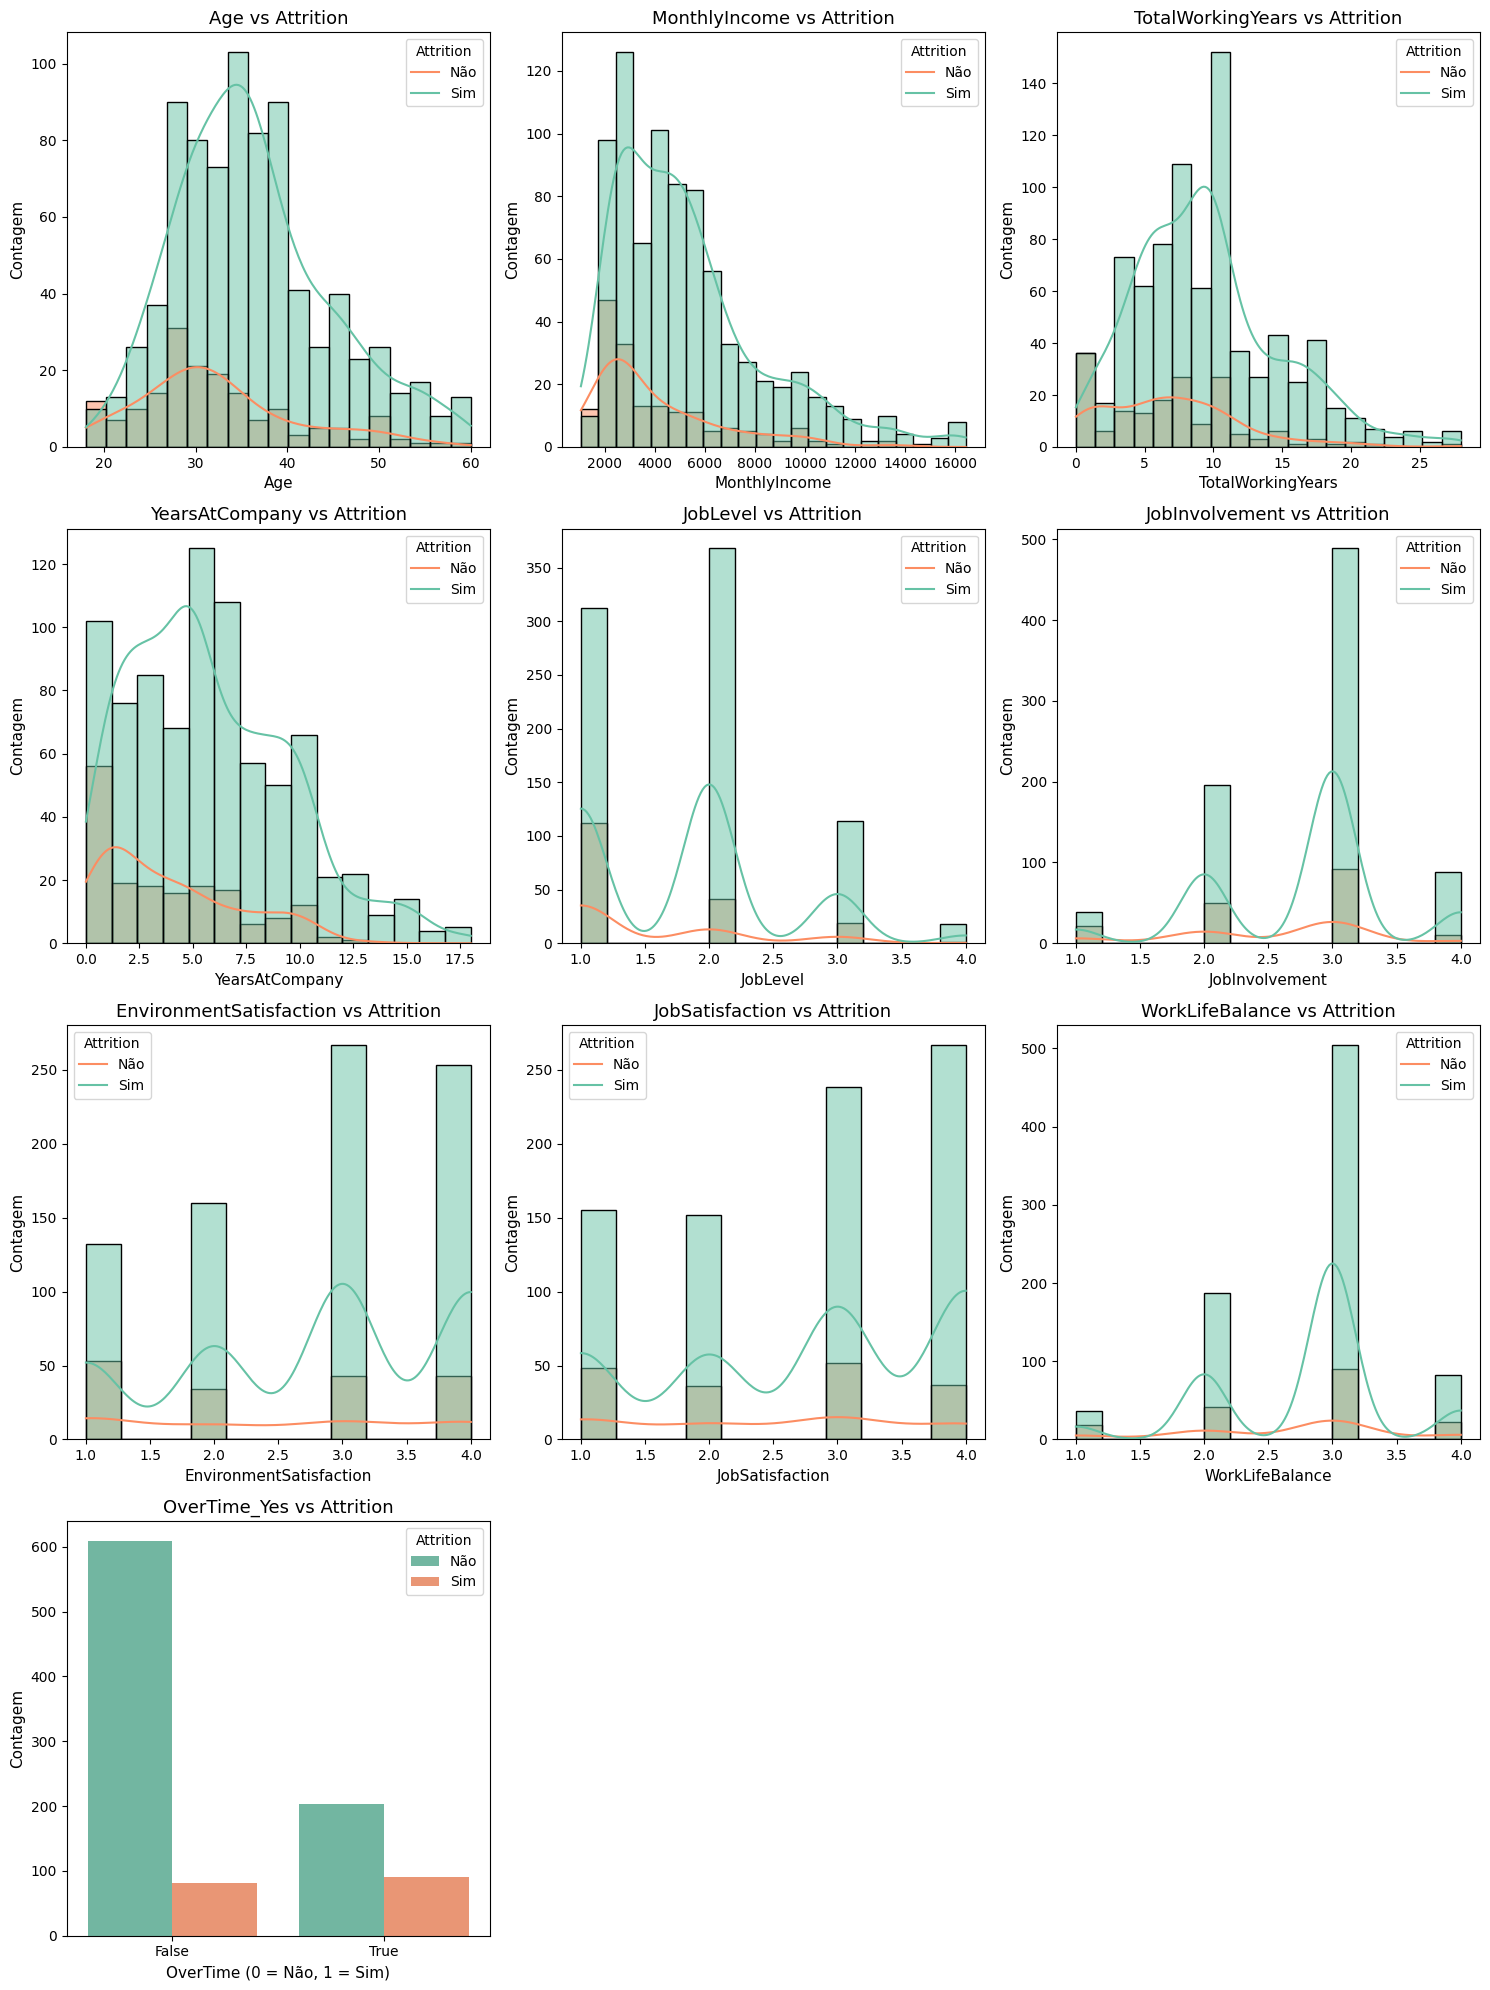

In [ ]:
# ================================
# Variáveis para explorar em relação à variável alvo (Attrition)
# ================================
variables_to_plot = [
    'Age',
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'JobLevel',
    'JobInvolvement',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'WorkLifeBalance',
    'OverTime_Yes'
]
# ================================
# Configuração do layout dos subplots
# ================================
n_cols = 3
n_rows = (len(variables_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# ================================
# Loop sobre cada variável e gera o gráfico correspondente
# ================================
for i, col in enumerate(variables_to_plot):

    if col == 'OverTime_Yes':
        sns.countplot(
            data=df_encoded,
            x=col,
            hue='Attrition',
            palette='Set2',
            ax=axes[i]
        )
        axes[i].set_xlabel('OverTime (0 = Não, 1 = Sim)', fontsize=11)
    else:
        sns.histplot(
            data=df,
            x=col,
            hue='Attrition',
            kde=True,
            palette='Set2',
            ax=axes[i]
        )
        axes[i].set_xlabel(col, fontsize=11)
    # ================================
    # Título e rótulos padronizados
    # ================================
    axes[i].set_title(f'{col} vs Attrition', fontsize=13)
    axes[i].set_ylabel('Contagem', fontsize=11)
    axes[i].legend(title='Attrition', labels=['Não', 'Sim'])

# ================================
# Remove subplots vazios, se houver
# ================================
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##Boxplots

Aqui vamos visualizar os boxplots para um subconjunto das variáveis numéricas com maior associação potencial com Attrition em um layout de subplots para simplificar a visualização.


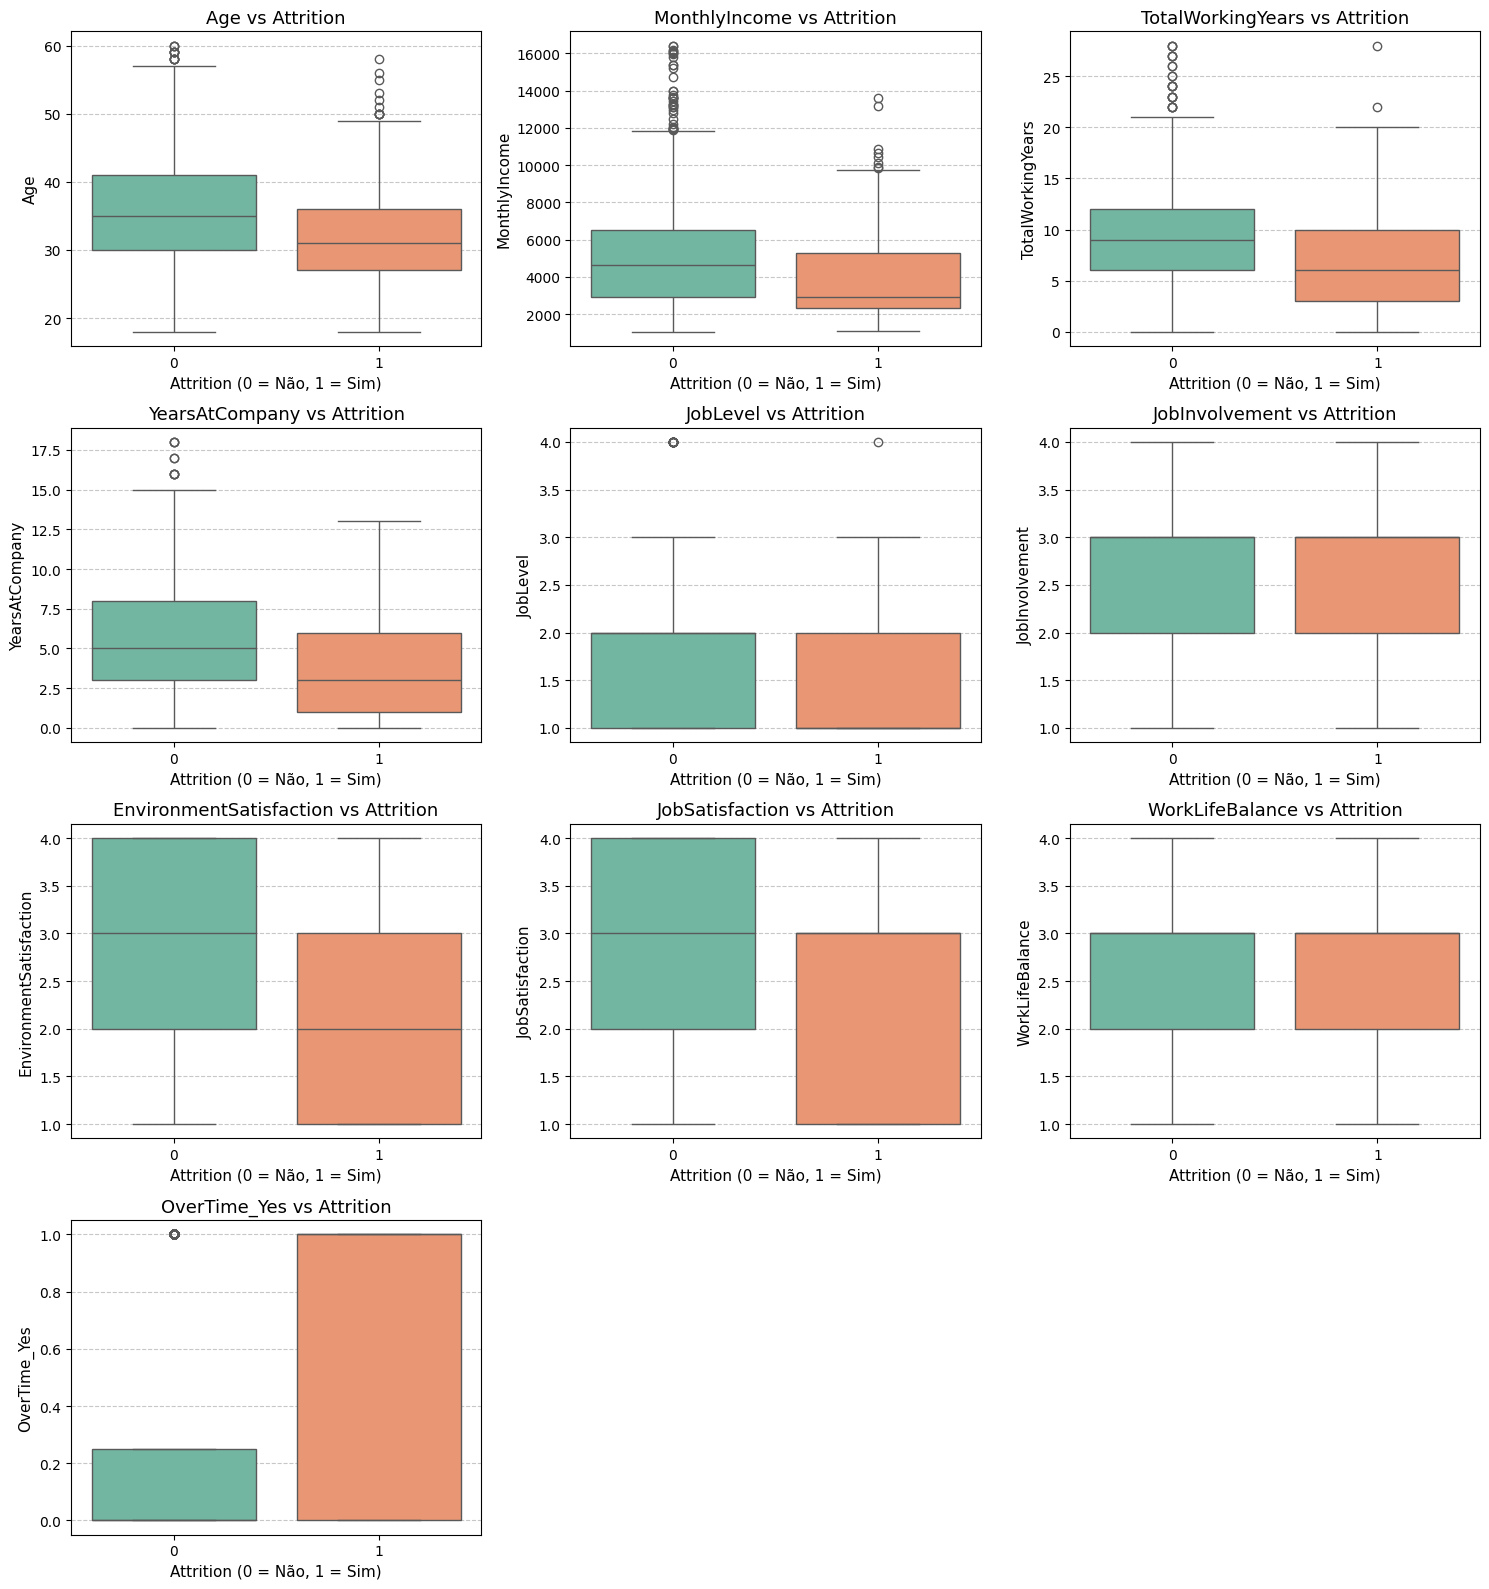

In [ ]:
# ================================
# Variáveis numéricas mais associadas ao Attrition (variável alvo)
# ================================
variables_to_plot = [
    'Age',
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'JobLevel',
    'JobInvolvement',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'WorkLifeBalance',
    'OverTime_Yes'  # Variável binária criada via codificação
]

# ================================
# Configuração dos subplots
# ================================
n_cols = 3
n_rows = (len(variables_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# ================================
# Geração dos boxplots
# ================================
for i, col in enumerate(variables_to_plot):

    sns.boxplot(
      data=df_encoded,
      x='Attrition',
      y=col,
      hue='Attrition',
      palette='Set2',
      legend=False,
      ax=axes[i]
  )

    # Títulos e rótulos consistentes
    axes[i].set_title(f'{col} vs Attrition', fontsize=13)
    axes[i].set_xlabel('Attrition (0 = Não, 1 = Sim)', fontsize=11)
    axes[i].set_ylabel(col, fontsize=11)

    # Linhas de grade horizontais para facilitar leitura
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# ================================
# Remove subplots vazios
# ================================
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##Matriz
É a vez do cálculo da matriz de correlação, criando um mapa de calor para visualizar as correlações entre as características numéricas.


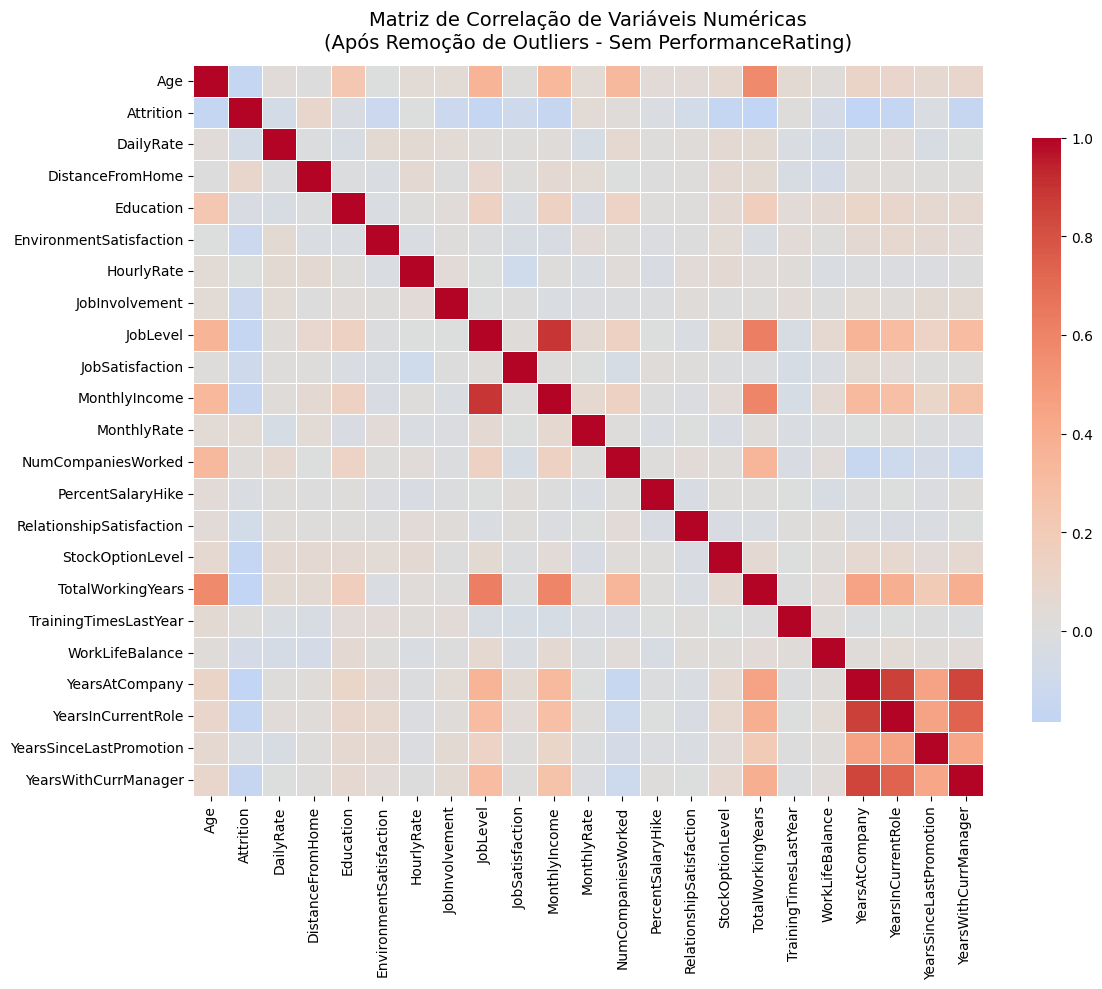

In [8]:
# ================================
# Cálculo da matriz de correlação (apenas variáveis numéricas)
# ================================
correlation_matrix = df.corr(numeric_only=True)

# Remover 'PerformanceRating', se tiver
correlation_matrix = correlation_matrix.drop(
    index='PerformanceRating', columns='PerformanceRating',
    errors='ignore'
)

# ================================
# Visualização: Mapa de calor
# ================================
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=False,
    cbar_kws={'shrink': 0.8}
)
plt.title(
    'Matriz de Correlação de Variáveis Numéricas\n(Após Remoção de Outliers - Sem PerformanceRating)',
    fontsize=14,
    pad=12
)
plt.tight_layout()
plt.show()

## Investigar associações
Com base nas visualizações, analisaremos quais variáveis parecem ter uma associação mais forte com a rotatividade.




Com base nas visualizações anteriores (histogramas, boxplots e heatmap), examinaremos as distribuições e correlações com 'Attrition' para identificar as variáveis numéricas com a associação mais forte com a rotatividade de funcionários e listá-las.



In [ ]:
# ================================
# Correlação com a variável alvo (Attrition)
# ================================
print("Correlação das variáveis numéricas com Attrition:\n")
corr_with_attrition = correlation_matrix['Attrition'].sort_values(ascending=False)
print(corr_with_attrition)

# ================================
# Interpretação baseada em correlação + análise visual prévia
# ================================
# Observando histogramas, boxplots e a matriz de correlação:
# - Idade, Renda Mensal, Anos Totais Trabalhados e Anos na Empresa apresentam diferenças mais relevantes
# - OverTime_Yes mostra forte associação positiva
# - Satisfação no trabalho e no ambiente, assim como StockOptionLevel, está tendo a correlação negativa
# - Variáveis como DailyRate, HourlyRate e MonthlyRate mostram correlação muito baixa
# - DistanceFromHome tem correlação positiva fraca
# - Education e PerformanceRating apresentam correlações praticamente nulas

# ================================
# Seleção de variáveis mais associadas ao Attrition
# ================================
variables_with_strongest_association = [
    'Age',
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsWithCurrManager',
    'JobLevel',
    'JobInvolvement',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'RelationshipSatisfaction',
    'WorkLifeBalance',
    'StockOptionLevel',
    'NumCompaniesWorked',
    'DistanceFromHome',
    'OverTime_Yes'
]

print("\nVariáveis selecionadas com maior potencial de associação com Attrition:\n")
print(variables_with_strongest_association)

Correlação das variáveis numéricas com Attrition:

Attrition                   1.000000
DistanceFromHome            0.091381
MonthlyRate                 0.042219
NumCompaniesWorked          0.025023
TrainingTimesLastYear       0.016713
HourlyRate                  0.001863
PercentSalaryHike          -0.019835
YearsSinceLastPromotion    -0.023220
Education                  -0.036148
WorkLifeBalance            -0.061888
DailyRate                  -0.074925
RelationshipSatisfaction   -0.077527
JobSatisfaction            -0.105703
EnvironmentSatisfaction    -0.122913
JobInvolvement             -0.129381
MonthlyIncome              -0.156975
YearsWithCurrManager       -0.160003
JobLevel                   -0.163603
StockOptionLevel           -0.165455
YearsInCurrentRole         -0.165642
Age                        -0.167547
TotalWorkingYears          -0.186137
YearsAtCompany             -0.186586
Name: Attrition, dtype: float64

Variáveis selecionadas com maior potencial de associação com Attr

##Modelagem e avaliação

Agora construiremos os modelos preditivos e avaliar os resultados.

LogisticRegression
              precision    recall  f1-score   support

           0      0.900     0.944     0.922       162
           1      0.667     0.514     0.581        35

    accuracy                          0.868       197
   macro avg      0.783     0.729     0.751       197
weighted avg      0.859     0.868     0.861       197

ROC AUC: 0.764
RandomForestClassifier
              precision    recall  f1-score   support

           0      0.856     0.994     0.920       162
           1      0.889     0.229     0.364        35

    accuracy                          0.858       197
   macro avg      0.873     0.611     0.642       197
weighted avg      0.862     0.858     0.821       197

ROC AUC: 0.789
XGBClassifier
              precision    recall  f1-score   support

           0      0.863     0.975     0.916       162
           1      0.714     0.286     0.408        35

    accuracy                          0.853       197
   macro avg      0.789     0.631     0.66

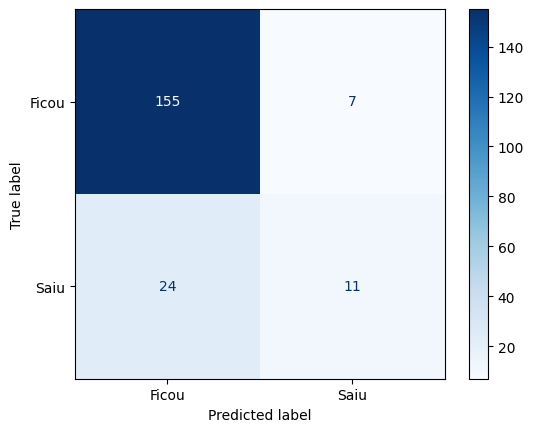

Falsos Positivos: 7 -> Prevê saída, mas ficou.
Falsos Negativos: 24 -> Prevê permanência, mas saiu.


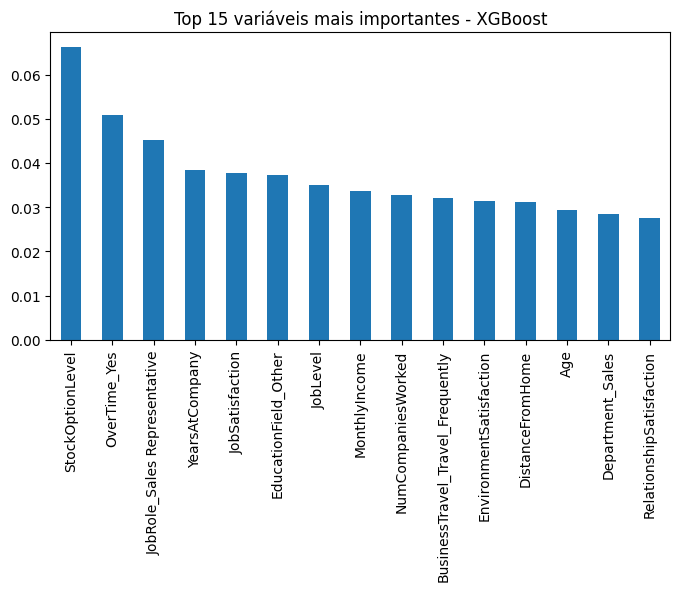

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)
from sklearn.model_selection import GridSearchCV
# ================================
# Função auxiliar para treino e avaliação
# ================================
def treinar_avaliar(modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    print(modelo.__class__.__name__)
    print(classification_report(y_test, y_pred, digits=3))
    if y_prob is not None:
        print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
    print("=" * 50)

    return {
        'modelo': modelo.__class__.__name__,
        'accuracy': (y_pred == y_test).mean(),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

# ================================
# Modelos baseline
# ================================
log_base = LogisticRegression(max_iter=500, random_state=42)
rf_base = RandomForestClassifier(random_state=42)
xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

resultados = []
resultados.append(treinar_avaliar(log_base, X_train, y_train, X_test, y_test))
resultados.append(treinar_avaliar(rf_base, X_train, y_train, X_test, y_test))
resultados.append(treinar_avaliar(xgb_base, X_train, y_train, X_test, y_test))

pd.DataFrame(resultados)

# ================================
# Tuning de hiperparâmetros
# ================================
# Logistic Regression
param_log = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid_log = GridSearchCV(LogisticRegression(max_iter=500, random_state=42),
                        param_log, cv=5, scoring='f1', n_jobs=-1)
grid_log.fit(X_train, y_train)

# Random Forest
param_rf = {'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# XGBoost
param_xgb = {'n_estimators': [100, 200],
             'max_depth': [3, 5, 7],
             'learning_rate': [0.01, 0.1, 0.2]}
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'),
                        param_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# ================================
# Avaliação com melhores parâmetros
# ================================
resultados_finais = []
resultados_finais.append(treinar_avaliar(grid_log.best_estimator_, X_train, y_train, X_test, y_test))
resultados_finais.append(treinar_avaliar(grid_rf.best_estimator_, X_train, y_train, X_test, y_test))
resultados_finais.append(treinar_avaliar(grid_xgb.best_estimator_, X_train, y_train, X_test, y_test))

pd.DataFrame(resultados_finais)

# ================================
# Avaliação de erros
# ================================
best_model = grid_xgb.best_estimator_  # Exemplo: usando XGBoost como melhor
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ficou', 'Saiu'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

fp = cm[0, 1]
fn = cm[1, 0]
print(f"Falsos Positivos: {fp} -> Prevê saída, mas ficou.")
print(f"Falsos Negativos: {fn} -> Prevê permanência, mas saiu.")

# ================================
# Importância das variáveis
# ================================
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(8,4))
plt.title("Top 15 variáveis mais importantes - XGBoost")
plt.show()

##SHAP
Aqui vamos implementar uma explicação do modelo usando a ferramenta SHAP para
mostrar de forma interpretável do porquê o modelo toma certas decisões.


In [ ]:
!pip install shap -q
import shap
import matplotlib.pyplot as plt

# Garantir uso do melhor modelo
best_model = grid_xgb.best_estimator_

# Criar explainador SHAP
explainer = shap.TreeExplainer(best_model)

# Calcular valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Summary Plot (impacto nas previsões de Attrition)
print("Gerando SHAP Summary Plot (impacto no risco de Attrition)...")
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    show=False
)
plt.title("Impacto das Variáveis no Risco de Attrition\n(>0 aumenta chance de sair, <0 reduz chance)")
plt.tight_layout()
plt.show()

# Gráfico de dependência para uma variável-chave
feature_name = "OverTime_Yes"
print(f"\nGerando SHAP gráfico de dependência para '{feature_name}' (impacto no Attrition)...")
shap.dependence_plot(
    feature_name,
    shap_values,
    X_test,
    interaction_index=None,
    show=False
)
plt.title(f"Impacto de '{feature_name}' no Risco de Attrition")
plt.tight_layout()
plt.show()

# Gráfico de cachoeira para explicação individual
instance_index = 0
print("\nGerando SHAP gráfico de cachoeira para um funcionário específico (impacto no Attrition)...")
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[instance_index],
    feature_names=X_test.columns.tolist(),
    max_display=10,
    show=False
)
plt.title("Principais Fatores que Influenciaram o Risco de Attrition\n(Funcionário selecionado)")
plt.tight_layout()
plt.show()

# Gráfico de Decisão
print("\nGerando SHAP Gráfico de Decisão (impacto no Attrition)...")
shap.decision_plot(
    explainer.expected_value,
    shap_values,
    X_test,
    feature_names=X_test.columns.tolist()
)